# Predicción del índice COLCAP usando Machine Learning
Este notebook implementa un flujo de trabajo completo para recolectar datos financieros relevantes,
procesarlos y entrenar un modelo que prediga el retorno diario del índice COLCAP en la Bolsa de Valores de Colombia.

# Fuentes de noticias financieras en COLOMBIA
- La republica
- Portafolio
- Dinero
- Portal bolsa de valores de colombia
- Super Intendencia Financiera de Colombia
---


In [1]:
!pip install yfinance scikit-learn pandas matplotlib

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📉 Error cuadrático medio (MSE): 0.0004379438225029673


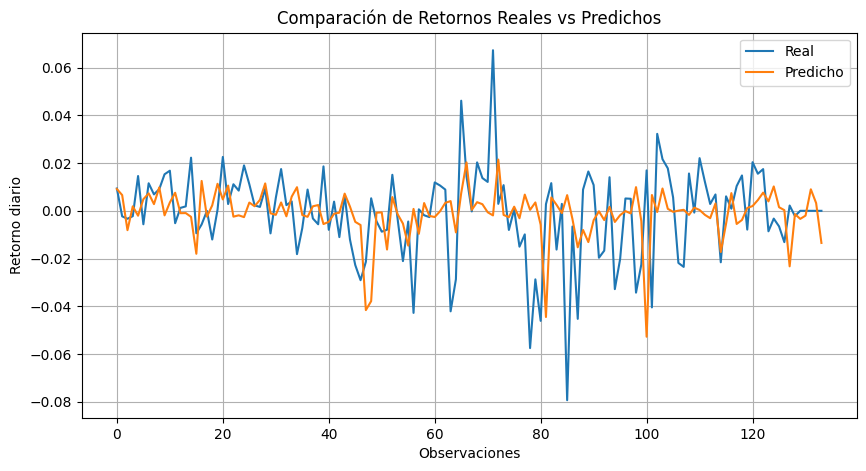

🔮 Predicción del retorno del ICOL (proxy COLCAP) para mañana: -1.35 %


In [7]:
# 🧩 Instalar dependencias necesarias
!pip install yfinance scikit-learn pandas matplotlib --quiet

# 📚 Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

# 🔧 Función para extraer columna 'Adj Close' o 'Close'
def get_close(df):
    if "Adj Close" in df.columns:
        return df["Adj Close"]
    elif "Close" in df.columns:
        return df["Close"]
    else:
        raise KeyError("No se encontró la columna 'Close' o 'Adj Close'")

# 📅 Definir rango de fechas
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# 📥 Descargar datos desde Yahoo Finance
icol = yf.download("ICOL", start=start_date, end=end_date)
brent = yf.download("BZ=F", start=start_date, end=end_date)
usdcop = yf.download("USDCOP=X", start=start_date, end=end_date)
vix = yf.download("^VIX", start=start_date, end=end_date)
sp500 = yf.download("^GSPC", start=start_date, end=end_date)

# 📈 Calcular retornos diarios
icol["ICOL_Return"] = get_close(icol).pct_change()
brent["Brent_Return"] = get_close(brent).pct_change()
usdcop["USDCOP_Return"] = get_close(usdcop).pct_change()
vix["VIX_Return"] = get_close(vix).pct_change()
sp500["SP500_Return"] = get_close(sp500).pct_change()

# 🧠 Construcción del DataFrame de modelado
df = pd.DataFrame({
    "ICOL_Return": icol["ICOL_Return"],
    "Brent_Return": brent["Brent_Return"],
    "USDCOP_Return": usdcop["USDCOP_Return"],
    "VIX_Return": vix["VIX_Return"],
    "SP500_Return": sp500["SP500_Return"]
})
df.dropna(inplace=True)

# 🛠️ Crear variables rezagadas (lag de 1 día)
df["Brent_lag1"] = df["Brent_Return"].shift(1)
df["USDCOP_lag1"] = df["USDCOP_Return"].shift(1)
df["ICOL_lag1"] = df["ICOL_Return"].shift(1)
df["VIX_lag1"] = df["VIX_Return"].shift(1)
df["SP500_lag1"] = df["SP500_Return"].shift(1)
df.dropna(inplace=True)

# 🔎 Seleccionar variables predictoras y objetivo
X = df[["Brent_lag1", "USDCOP_lag1", "ICOL_lag1", "VIX_lag1", "SP500_lag1"]]
y = df["ICOL_Return"]

# ✂️ Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🎯 Entrenar modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📊 Evaluar modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("📉 Error cuadrático medio (MSE):", mse)

# 📈 Visualizar resultados
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicho")
plt.legend()
plt.title("Comparación de Retornos Reales vs Predichos")
plt.xlabel("Observaciones")
plt.ylabel("Retorno diario")
plt.grid(True)
plt.show()

# 🔮 Predicción para mañana
X_today = X.iloc[[-1]]
pred = model.predict(X_today)[0]
print("🔮 Predicción del retorno del ICOL (proxy COLCAP) para mañana:", round(pred * 100, 2), "%")
